Libraries

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

import os
import seaborn as sns

import model1/model2 ?

# Loading and preparing dataset

Image and training parameters

In [19]:
img_size = (224, 224)
batch_size = 32
seed = 42

Load training dataset

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/brain-tumor-mri-dataset/Training',
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


Load validation dataset

In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/brain-tumor-mri-dataset/Training',
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Load testing dataset

In [22]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/brain-tumor-mri-dataset/Testing',
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1311 files belonging to 4 classes.


Class labels

In [23]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


Optimize with prefetching

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Preview a batch of training images

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_index])
        plt.axis("off")

# Import & Prepare EfficientNetB0



Number of classes

In [ ]:
num_classes=len(class_names)

Build model

In [27]:

base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Freeze base model initially

In [28]:
base_model.trainable = False

Add custom top layers

In [29]:
model = models.Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.4),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(4, activation='softmax')
])

Compile the model

In [30]:
model.compile(
  optimizer=Adam(learning_rate=1e-3),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Callbacks

In [31]:
# 1. Early stopping (to prevent overfitting)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True,
  verbose=1
)

# 2. Model checkpoint (save best weights)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
  filepath='/kaggle/working/Dense_best_model.keras',
  monitor='val_loss',
  save_best_only=True,
  save_weights_only=False,
  verbose=1
)

# 3. Reduce learning rate if validation stops improving
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.2,
  patience=2,
  verbose=1,
  min_lr=1e-7
)

Train the Model

In [32]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/20


I0000 00:00:1749496080.098240      96 service.cc:148] XLA service 0x7b8264003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749496080.099389      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749496082.978236      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/143 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2422 - loss: 5.8251   

I0000 00:00:1749496094.350542      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4654 - loss: 2.4354
Epoch 1: val_loss improved from inf to 0.79780, saving model to /kaggle/working/Dense_best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 310ms/step - accuracy: 0.4660 - loss: 2.4291 - val_accuracy: 0.8144 - val_loss: 0.7978 - learning_rate: 0.0010
Epoch 2/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6222 - loss: 0.9281
Epoch 2: val_loss improved from 0.79780 to 0.33617, saving model to /kaggle/working/Dense_best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.6226 - loss: 0.9274 - val_accuracy: 0.9772 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6828 - loss: 0.7872
Epoch 3: val_loss did not improve from 0.33617
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6829 - loss: 0.7871 - val_accuracy: 0.9457 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy:

Saving model

In [33]:
model.save('/kaggle/working/DenseNet121_trained.keras')
model.save('DenseNet121_trained.keras')

Plot Training Curves

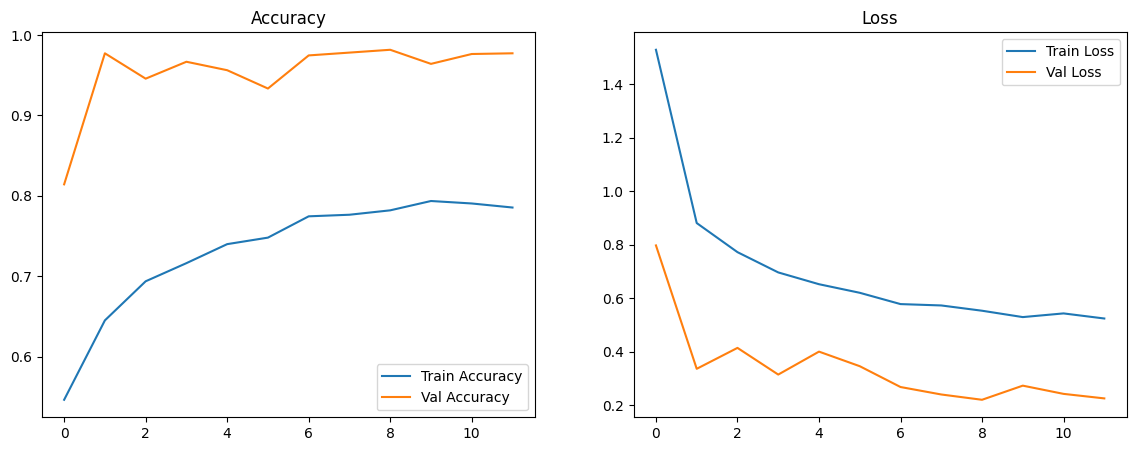

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Evaluate DenseNet

In [36]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.7196 - loss: 0.6226
Test Accuracy: 0.8055
Test Loss: 0.4838


41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 338ms/step
              precision    recall  f1-score   support

      glioma       0.89      0.70      0.78       300
  meningioma       0.69      0.52      0.59       306
     notumor       0.81      0.98      0.89       405
   pituitary       0.82      0.97      0.89       300

    accuracy                           0.81      1311
   macro avg       0.80      0.79      0.79      1311
weighted avg       0.80      0.81      0.79      1311



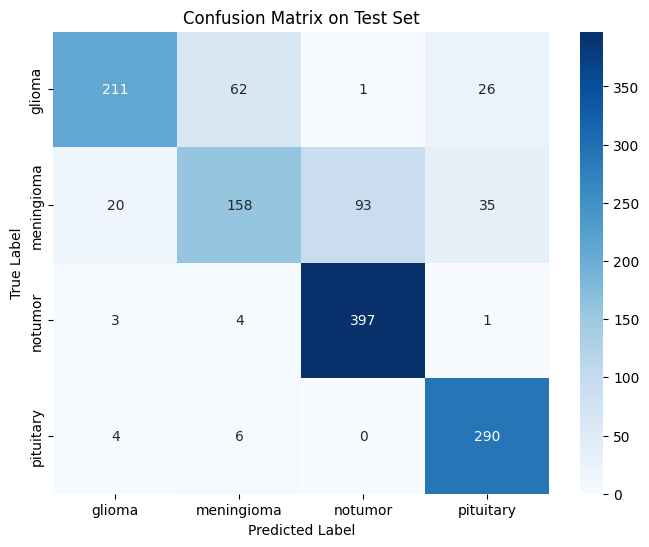

In [37]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_classes = np.argmax(true_labels, axis=1)
pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)

print(classification_report(true_classes, pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


## Evaluate/Test on Individual Images

In [38]:
# Class names (adjust if needed)
class_names = class_names

def predict_image(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Make it batch shape

    # Predict
    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions)]

    # Show result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class}")
    plt.show()

    return pred_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


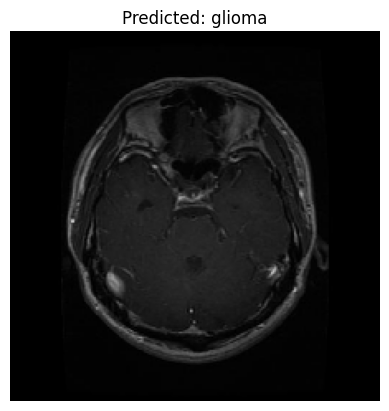

'glioma'

In [39]:
predict_image("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0012.jpg", model)

 # Prepare DenseNet Fine_Tune

In [40]:
# 1. Early stopping (to prevent overfitting)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True,
  verbose=1
)

# 2. Model checkpoint (save best weights)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
  filepath='/kaggle/working/Dense_fine-tune.keras',
  monitor='val_loss',
  save_best_only=True,
  save_weights_only=False,
  verbose=1
)

# 3. Reduce learning rate if validation stops improving
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.2,
  patience=2,
  verbose=1,
  min_lr=1e-7
)

In [41]:
base_model.trainable = True

# Optionally freeze early layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Recompile with lower LR
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 6,412,612 (24.46 MB)

 Non-trainable params: 888,320 (3.39 MB)

In [42]:
# Fine-tune the model
fine_tune_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.5163 - loss: 1.2741
Epoch 1: val_loss improved from inf to 0.34273, saving model to /kaggle/working/Dense_fine-tune.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 246s 727ms/step - accuracy: 0.5170 - loss: 1.2721 - val_accuracy: 0.9352 - val_loss: 0.3427 - learning_rate: 1.0000e-05
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7874 - loss: 0.5497
Epoch 2: val_loss improved from 0.34273 to 0.13052, saving model to /kaggle/working/Dense_fine-tune.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.7876 - loss: 0.5495 - val_accuracy: 0.9799 - val_loss: 0.1305 - learning_rate: 1.0000e-05
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8515 - loss: 0.3868
Epoch 3: val_loss improved from 0.13052 to 0.07730, saving model to /kaggle/working/Dense_fine-tune.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.8516 - loss: 0.3866 - val_accuracy: 0.9904 - val_loss: 0.0773 - lea

In [43]:
model.save('/kaggle/working/DenseNet121_Fine-Tune.keras')
model.save('DenseNet121_Fine-Tune.keras')

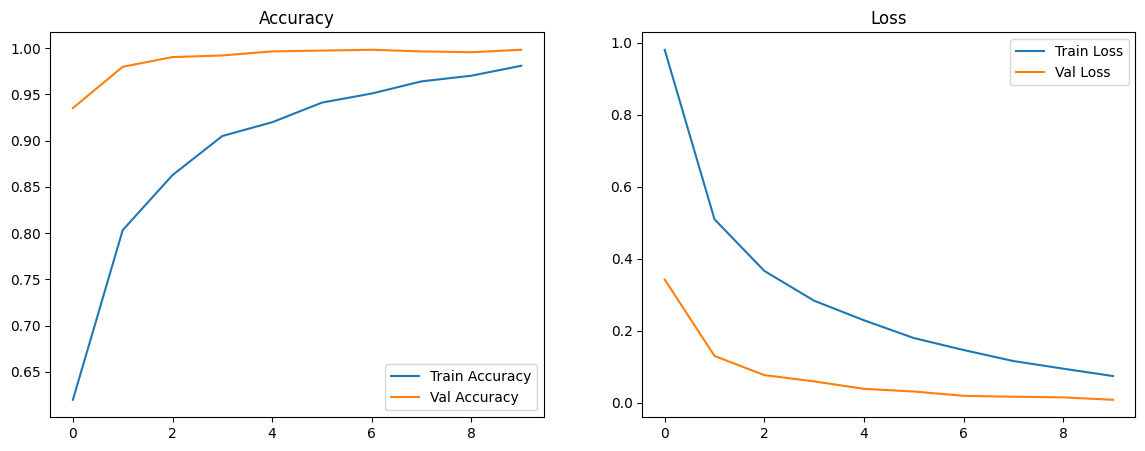

In [44]:
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Evaluate

In [45]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9498 - loss: 0.1305
Test Accuracy: 0.9649
Test Loss: 0.0944


41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.93      0.93      0.93       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.96      0.96      1311



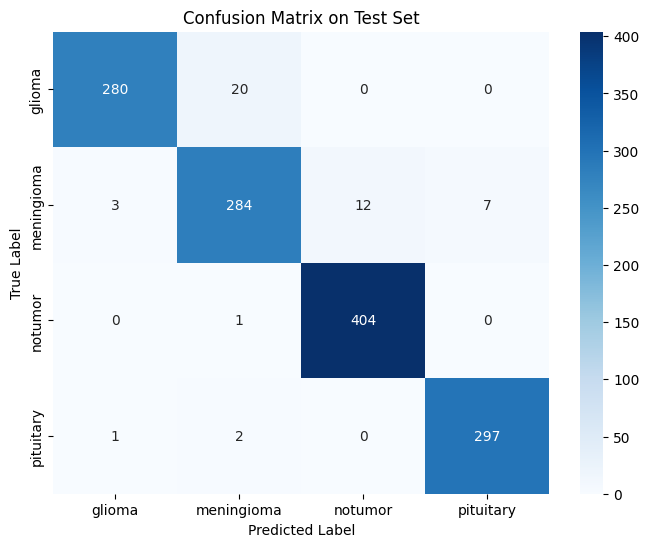

In [46]:
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_classes = np.argmax(true_labels, axis=1)

pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)

print(classification_report(true_classes, pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


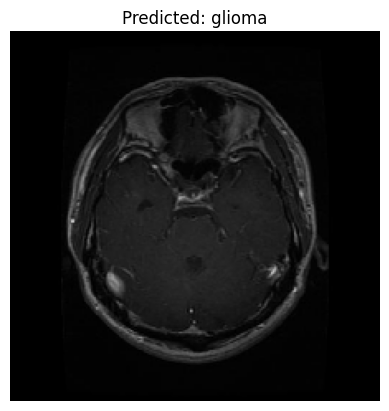

'glioma'

In [47]:
predict_image("/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0012.jpg", model)